In [59]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [60]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [61]:
# 데이터 변환 정의 (정규화 포함)
transform = transforms.Compose([
    transforms.ToTensor(),  # PIL이나 numpy를 tensor로 변환하고 [0,1]로 정규화
])

# 데이터셋 로드
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transform)

print(f"훈련 데이터 개수: {len(train_dataset)}")
print(f"테스트 데이터 개수: {len(test_dataset)}")

훈련 데이터 개수: 60000
테스트 데이터 개수: 10000


이미지 모양: torch.Size([1, 28, 28])
레이블: 5


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48660 (\N{HANGUL SYLLABLE BEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


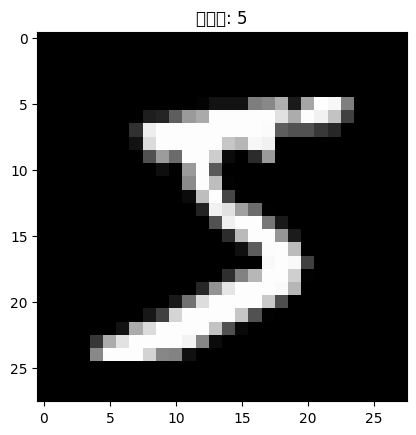

In [62]:
# 첫 번째 샘플 확인
image, label = train_dataset[0]
print(f"이미지 모양: {image.shape}")
print(f"레이블: {label}")

# 이미지 시각화
plt.imshow(image.squeeze(), cmap='gray')  # squeeze()로 (1, 28, 28) -> (28, 28)
plt.title(f"레이블: {label}")
plt.show()

In [73]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, (3, 3))
        self.conv2 = nn.Conv2d(32, 64, (3, 3))
        self.pool1 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(1600, 10)

    def forward(self, x):
        # 여기에 데이터가 어떻게 흘러갈지 정의할 거예요
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x) # 크기를 더 줄이고 중요한 특징만 남김

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool1(x)

        x = torch.flatten(x, 1) # [1, 1600] => [1, 64 * 5 * 5]

        x = self.fc1(x)

        return x

In [75]:
model = CNN()
print(model)

# 테스트용 데이터로 모델이 잘 작동하는지 확인
test_input = torch.randn(1, 1, 28, 28)  # (배치크기, 채널, 높이, 너비)
output = model(test_input)
print(f"입력 모양: {test_input.shape}")
print(f"출력 모양: {output.shape}")
print(f"출력값: {output}")

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=10, bias=True)
)
입력 모양: torch.Size([1, 1, 28, 28])
출력 모양: torch.Size([1, 10])
출력값: tensor([[-0.0926,  0.4829,  0.1508, -0.2007,  0.4700,  0.1705,  0.1251, -0.2830,
         -0.3291, -0.2596]], grad_fn=<AddmmBackward0>)


In [76]:
import torch.optim as optim

# 손실함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)  # 학습률 0.001

In [77]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [79]:
def test_accuracy():
    model.eval()  # 평가 모드로 설정
    correct = 0
    total = 0

    with torch.no_grad():  # 기울기 계산 안함
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)  # 가장 높은 점수의 클래스
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print(f'테스트 정확도: {accuracy:.2f}%')
    return accuracy

In [81]:
num_epochs = 5

In [86]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()  # 이게 빠졌어요!
        total_loss += loss.item()

        if batch_idx % 100 == 0:  # 이 if문이 for 루프 안으로 들어와야 해요
            print(f'에포크 {epoch+1}/{num_epochs}, 배치 {batch_idx}, 손실: {loss.item():.6f}')

    # 에포크 끝날 때마다 (for 루프와 같은 들여쓰기)
    avg_loss = total_loss / len(train_loader)
    print(f'\n에포크 {epoch+1} 완료 - 평균 손실: {avg_loss:.6f}')
    test_accuracy()
    print("-" * 50)

에포크 1/5, 배치 0, 손실: 0.132704
에포크 1/5, 배치 100, 손실: 0.098582
에포크 1/5, 배치 200, 손실: 0.046018
에포크 1/5, 배치 300, 손실: 0.113266
에포크 1/5, 배치 400, 손실: 0.034198
에포크 1/5, 배치 500, 손실: 0.061688
에포크 1/5, 배치 600, 손실: 0.008964
에포크 1/5, 배치 700, 손실: 0.031194
에포크 1/5, 배치 800, 손실: 0.096051
에포크 1/5, 배치 900, 손실: 0.018209

에포크 1 완료 - 평균 손실: 0.043112
테스트 정확도: 98.70%
--------------------------------------------------
에포크 2/5, 배치 0, 손실: 0.057081
에포크 2/5, 배치 100, 손실: 0.010149
에포크 2/5, 배치 200, 손실: 0.021143
에포크 2/5, 배치 300, 손실: 0.036342
에포크 2/5, 배치 400, 손실: 0.073014
에포크 2/5, 배치 500, 손실: 0.004119
에포크 2/5, 배치 600, 손실: 0.230401
에포크 2/5, 배치 700, 손실: 0.009652
에포크 2/5, 배치 800, 손실: 0.017883
에포크 2/5, 배치 900, 손실: 0.010517

에포크 2 완료 - 평균 손실: 0.034431
테스트 정확도: 98.94%
--------------------------------------------------
에포크 3/5, 배치 0, 손실: 0.010962
에포크 3/5, 배치 100, 손실: 0.009389
에포크 3/5, 배치 200, 손실: 0.002666
에포크 3/5, 배치 300, 손실: 0.012559
에포크 3/5, 배치 400, 손실: 0.076947
에포크 3/5, 배치 500, 손실: 0.025823
에포크 3/5, 배치 600, 손실: 0.008966
에포크 3/

In [87]:
import numpy as np

# 테스트 데이터에서 몇 개 샘플 가져오기
model.eval()
test_samples = []
test_labels = []

with torch.no_grad():
    for i in range(10):  # 처음 10개
        image, label = test_dataset[i]
        test_samples.append(image)
        test_labels.append(label)

# 배치로 만들기
test_batch = torch.stack(test_samples)
test_labels = torch.tensor(test_labels)

# 예측
predictions = model(test_batch)
predicted_classes = torch.argmax(predictions, dim=1)

print("실제 레이블:", test_labels.numpy())
print("예측 레이블:", predicted_classes.numpy())

실제 레이블: [7 2 1 0 4 1 4 9 5 9]
예측 레이블: [7 2 1 0 4 1 4 9 5 9]


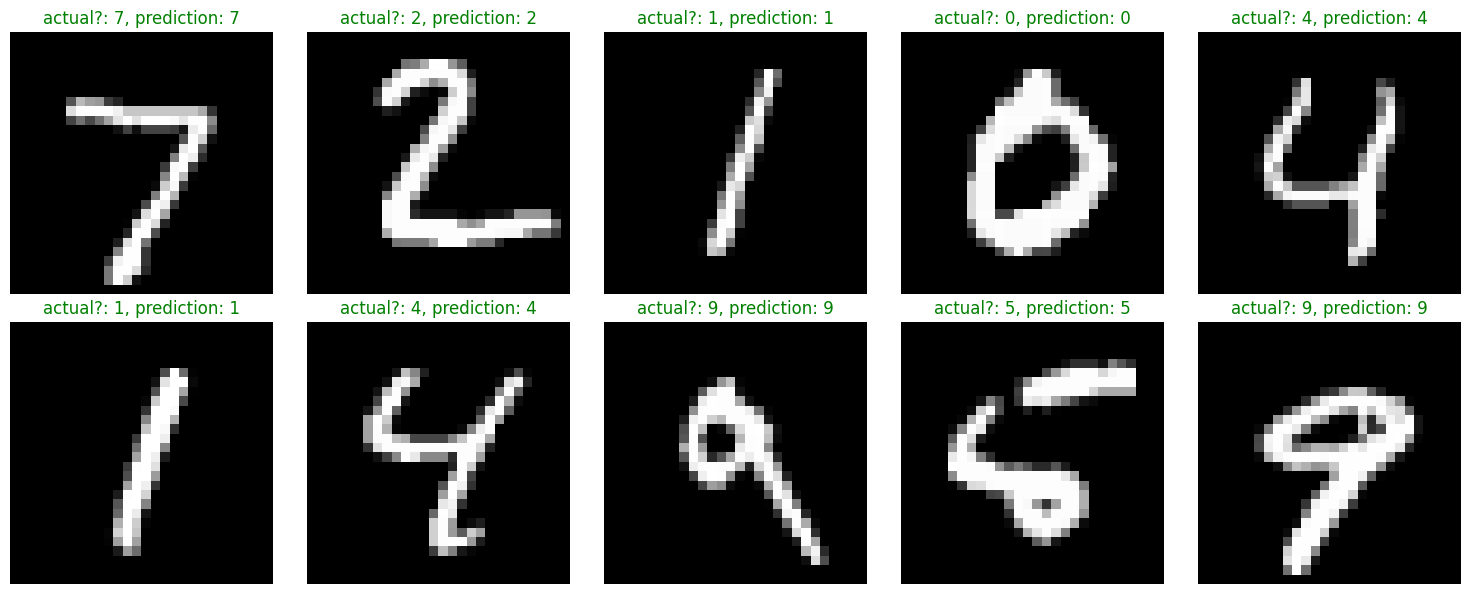

In [89]:
import matplotlib.pyplot as plt

# 시각화
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # 이미지 표시 (채널 차원 제거)
    plt.imshow(test_samples[i].squeeze(), cmap='gray')

    # 제목에 실제 vs 예측 표시
    actual = test_labels[i].item()
    predicted = predicted_classes[i].item()

    # 맞으면 초록색, 틀리면 빨간색
    color = 'green' if actual == predicted else 'red'
    plt.title(f'actual?: {actual}, prediction: {predicted}', color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()